# 线性回归

- 数据集 $D={(x_1, y_1),(x_2, y_2),...,(x_N, y_N)}, x_i \in \mathbb{R}^p,y_i \in \mathbb{R}, i = 1, 2, ..., N$
- $X = (x_1, x_2, ..., x_N) ^T = $$\begin{bmatrix}
{x_{11}}&{x_{12}}&{\cdots}&{x_{1p}}\\
{x_{21}}&{x_{22}}&{\cdots}&{x_{2p}}\\
{\vdots}&{\vdots}&{\ddots}&{\vdots}\\
{x_{N1}}&{a_{N2}}&{\cdots}&{x_{Np}}\\
\end{bmatrix}_{N*P}$$ , y = $$\begin{bmatrix}
{y_{1}}\\
{y_{2}}\\
{\vdots}\\
{y_{N}}\\
\end{bmatrix}_{N*1}$$ $

## 最小二乘估计

- 损失函数：$L(w)=\sum\limits_{i=1}^N(W^Tx_i-y_i)^2=W^TX^TXW-2W^TX^TY+Y^TY$,$W$为待估计参数
- 最优参数$\hat{W}=\arg\underset{W}\max L(W)$
- 求解：$\frac{\partial L(W)} {\partial W}=2X^TXW-2X^TY$，由偏导数为0得到$X^TXW-X^TY=0 \Rightarrow X^TXW=X^TY \Rightarrow W=(X^TX)^{-1}X^TY$

## 贝叶斯视角

给定$x_i, w$的情况下,求y最可能的取值
- 假设误差$\epsilon \sim N(0, \sigma^2), y= W^TX+\epsilon, y|_{X,w} \sim N(W^TX, \sigma^2)$
- 极大似然估计：$L(W) = log (\prod\limits_{i=1}^N p(y_i|_{x_i,w}) )=\sum\limits_{i=1}^Nlog(p(y_i|_{x_i,w}))=\sum\limits_{i=1}^N(log\frac{1}{\sqrt{2\pi}\sigma}-\frac{1}{2\sigma^2}(y_i-W^Tx_i)^2)$
- 最优参数$\hat{W}= \arg\underset{W}\max L(W)=\arg\underset{W}\max \sum\limits_{i=1}^N-\frac{1}{2\sigma^2}(y_i-W^Tx_i)^2=\arg\underset{W}\min \sum\limits_{i=1}^N (W^Tx_i-y_i)^2$

# Ridge回归
带l2正则化项的线性回归

- 损失函数: $L(w)=\sum\limits_{i=1}^N(W^Tx_i-y_i)^2 + \lambda W^TW=W^TX^TXW-2W^TX^TY+Y^TY + \lambda W^TIW$
- 最优参数$\hat{W}=\arg\underset{W}\max L(W)$
- 求解：$\frac{\partial L(W)} {\partial W}=2X^TXW-2X^TY + 2\lambda IW$，由偏导数为0得到$X^TXW-X^TY+\lambda IW=0 \Rightarrow X^TXW+\lambda IW=X^TY \Rightarrow W=(X^TX + \lambda I)^{-1}X^TY$

## 贝叶斯视角
假设$W$的先验分布为高斯分布(LASSO回归中$W$的先验分布为拉普拉斯分布)

- 假设$w_i \sim N(0, \sigma_o^2),则p(w)=\frac{1}{\sqrt{2\pi}\sigma_o} \exp\left\{-\frac{||w||^2}{2\sigma_o^2}\right\},p(y|_w)=\frac{1}{\sqrt{2\pi}\sigma} \exp\left\{-\frac{||y-W^T||^2}{2\sigma^2}\right\}$
- 求W的最大后验估计:

<center> $\begin{aligned}
\hat{W}&=\arg\underset{W}\max  p(w|y) \\
&=\arg\underset{W}\max \frac{p(y|w)p(w)}{p(y)} \\
&=\arg\underset{W}\max p(y|w)p(w) \\
&=\arg\underset{W}\max \log {p(y|w)p(w)}\\
&=\arg\underset{W}\max \log {\frac{1}{\sqrt{2\pi}\sigma_o\sqrt{2\pi}\sigma}} + \log \exp\left\{-\frac{||y-W^T||^2}{2\sigma^2} -\frac{||w||^2}{2\sigma_o^2} \right\}\\
&=\arg\underset{W}\min \frac{||y-W^T||^2}{2\sigma^2}+ \frac{||w||^2}{2\sigma_o^2} \\
&=\arg\underset{W}\min ||y-W^T||^2+ \frac{\sigma^2}{\sigma_o^2} ||w||^2\\
&=\arg\underset{W}\min ||y-W^T||^2+ \lambda ||w||^2(\lambda = \frac{\sigma^2}{\sigma_o^2})\\
\end{aligned}$

# 定义工具函数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

In [2]:
class LinearRegression():
    """
    Parameters:
    -----------
    n_iterations: int
        梯度下降的轮数
    learning_rate: float
        梯度下降学习率
    regularization: l1_regularization or l2_regularization or None
        正则化
    gradient: Bool
        是否采用梯度下降法或正规方程法。
        若使用了正则化，暂只支持梯度下降
    """

    def __init__(self, n_iterations=3000, learning_rate=0.00005, regularization=None, gradient=True):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.gradient = gradient
        if regularization == None:
            self.regularization = lambda x: 0
            self.regularization.grad = lambda x: 0
        else:
            self.regularization = regularization

    def initialize_weights(self, n_features):
        # 初始化参数
        limit = np.sqrt(1 / n_features)
        w = np.random.uniform(-limit, limit, (n_features, 1))
        b = 0
        self.w = np.insert(w, 0, b, axis=0)
        
    def fit(self, X, y):                
        m_samples, n_features = X.shape
        self.initialize_weights(n_features)
        X = np.insert(X, 0, 1, axis=1)
        y = np.reshape(y, (m_samples, 1))
        self.training_errors = []
        if self.gradient == True:

            # 梯度下降
            for i in range(self.n_iterations):
                y_pred = X.dot(self.w)
                loss = np.mean(0.5 * (y_pred - y) ** 2) + self.regularization(self.w) #计算loss
                if len(self.training_errors) > 10 and np.abs(self.training_errors[-10] - loss) < 0.0001:
                    return 
                self.training_errors.append(loss)

                
                w_grad = X.T.dot(y_pred - y) / m_samples + self.regularization.grad(self.w)  # (y_pred - y).T.dot(X)，计算梯度
                self.w -= self.learning_rate * w_grad #更新权值w
                
        else:
            # 正规方程
            X = np.matrix(X)
            y = np.matrix(y)
            X_T_X = X.T.dot(X)
            X_T_X_I_X_T = X_T_X.I.dot(X.T)
            X_T_X_I_X_T_X_T_y = X_T_X_I_X_T.dot(y)
            self.w = X_T_X_I_X_T_X_T_y

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

In [3]:
X, y = make_regression(n_samples=100, n_features=1, noise=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
n_samples, n_features = np.shape(X)

In [4]:
class regularization():
    def __init__(self, alpha, l1=False, l2=False):
        self.alpha = alpha
        self.l1 = l1
        self.l2 = l2
        
    # 正则化的方差
    def __call__(self, w):
        loss = 0
        
        if self.l1:
            loss += np.sum(np.fabs(w))
        
        if self.l2:
            loss += 0.5 * w.T.dot(w)[0][0]
            
        return self.alpha * loss

    # 正则化的梯度
    def grad(self, w):
        grad = np.zeros_like(w)
        if self.l1:
            grad += np.sign(w)
        
        if self.l2:
            grad += w
        return self.alpha * grad

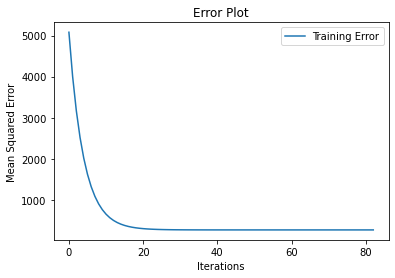

Mean squared error: 479.35754319529605


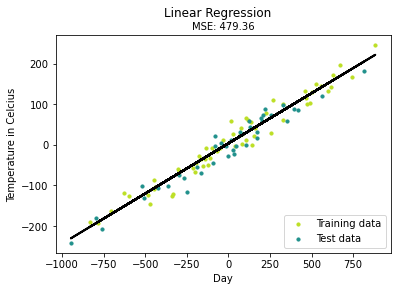

In [5]:
# # 可自行设置模型参数，如正则化，梯度下降轮数学习率等
model = LinearRegression(n_iterations=100, learning_rate=1e-1, regularization=regularization(alpha=0.5, l1=True))
# from sklearn.linear_model import LinearRegression as lr
# model = lr()
model.fit(X_train, y_train)

# Training error plot 画loss的图
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()

y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred, y_test.shape)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %s" % (mse))

y_pred_line = model.predict(X)

# Color map
cmap = plt.get_cmap('viridis')

# Plot the results，画拟合情况的图
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()